In [77]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import numpy as np

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_feature_film_series_with_two_entries"

In [3]:
r = requests.get(url)

In [4]:
soup = BeautifulSoup(r.text, 'html.parser')

In [5]:
#mix the soup
m = [item.get_text().split('\n') for item in soup.find_all('ol')]

In [85]:
#Quick function to query the OMDB API
def make_text(text, column):
    try:
        return text[column]
    except:
        return "N/A"

counter = 0

def query_api(title, year):
    
    url = 'http://www.omdbapi.com'
    
    #Handle String years if necessary
    try:
        year = str(int(year))
    except:
        year = 'N/A'
    
    #Populate Params
    params = {'t': title,
           'y': year,
           'apikey': 'f13c3a86'}

    global counter
    counter = counter + 1
    print(counter, title)
    
    #Make the request
    try:
        r = requests.get(url, params=params, timeout=0.6)

        response = r.text
        print(response)

        json_text = json.loads(response)
    except Exception as e:
        print(e)
        r = 0
    
    try:
        #Populate imdbRating
        '''
        try:
            imdb = json_text['imdbRating']
        except:
            imdb = 'N/A'
        '''
        imdb = make_text(json_text, 'imdbRating')

        #Populate Metascore Rating
        '''
        try:
            metascore = json_text['Metascore']
        except:
            metascore = 'N/A'
        ''' 
        metascore = make_text(json_text, 'Metascore')
        #print(imdb, metascore)
    except:
        imdb = 'N/A'
        metascore = 'N/A'
    
    return {'imdb': imdb, 'metascore': metascore}

In [19]:
#Find all movies
l = [item.text.split('\n') for item in soup.find('div', {'class': 'div-col'}).find_all('li')]

In [20]:
#Remove anything that doesn't have 3 entries
'''
def filterList(item):
    return len(item) == 3
'''

clean_list = list(filter(lambda x: len(x) == 3, l))

In [21]:
#TODO: refactor to work with more than 2 movies
titles = [[{'title':item[1], 'series': item[0]}, {'title':item[2], 'series':item[0]}] for item in clean_list]

In [22]:
#Flatten the list to create a dataframe
df = pd.DataFrame([item for sublist in titles for item in sublist])

In [23]:
#Create a new column by parsing out the date
def return_date(item):
    try:
        return item.split('(')[1].split(')')[0]
    except:
        return np.nan
    
df['date'] = df['title'].apply(lambda x:return_date(x))
df['title_clean'] = df['title'].apply(lambda x: x.split('(')[0])

In [24]:
df

,title,series,date,title_clean
0,00 Schneider – Jagd auf Nihil Baxter (1994),00 Schneider,1994,00 Schneider – Jagd auf Nihil Baxter
1,00 Schneider – Im Wendekreis der Eidechse [de]...,00 Schneider,2013,00 Schneider – Im Wendekreis der Eidechse [de]
2,2 Days in Paris (2007),2 Days in...,2007,2 Days in Paris
3,2 Days in New York (2012),2 Days in...,2012,2 Days in New York
4,8mm (1999),8mm,1999,8mm
...,...,...,...,...
3347,Zulu Dawn (1979) (prequel),Zulu,1979,Zulu Dawn
3348,Zuma (1985),Zuma,1985,Zuma
3349,Anak ni Zuma (1987),Zuma,1987,Anak ni Zuma
3350,Dschungelmädchen für zwei Halunken [de] (1974),Zwei Teufelskerle,1974,Dschungelmädchen für zwei Halunken [de]


In [25]:
#Converte the date column to be and integer
def convert_to_int(item):
    try:
        return float(item)
    except:
        return np.nan

df['date'] = df['date'].apply(lambda x: convert_to_int(x))

In [86]:
#Only keep movies newer than 1990 and let's only worry about the first 100
test_df = df.loc[df['date'] > 1990].copy()

In [80]:
#test_df

In [87]:
#Query the API for each entry and keep building the table
final_df = test_df.merge(test_df.apply(lambda x: pd.Series(query_api(x['title_clean'], x['date'])), axis=1), 
             left_index=True, right_index=True)

com/images/M/MV5BMjE0MDM3NzEzOF5BMl5BanBnXkFtZTgwMDc0Njg5MTE@._V1_SX300.jpg","Ratings":[{"Source":"Internet Movie Database","Value":"5.5/10"},{"Source":"Rotten Tomatoes","Value":"65%"}],"Metascore":"N/A","imdbRating":"5.5","imdbVotes":"6,075","imdbID":"tt2781516","Type":"movie","DVD":"09 Mar 2015","BoxOffice":"N/A","Production":"Echolands Creative Group","Website":"N/A","Response":"True"}
1749 Another WolfCop 
{"Response":"False","Error":"Movie not found!"}
1750 Wow! Wow! Wubbzy!: Wubbzy's Big Movie! 
{"Response":"False","Error":"Movie not found!"}
1751 Wow! Wow! Wubbzy!: Wubb Idol 
{"Response":"False","Error":"Movie not found!"}
1752 Wreck-It Ralph 
{"Title":"Wreck-It Ralph","Year":"2012","Rated":"PG","Released":"02 Nov 2012","Runtime":"101 min","Genre":"Animation, Adventure, Comedy, Family, Fantasy","Director":"Rich Moore","Writer":"Rich Moore (story by), Phil Johnston (story by), Jim Reardon (story by), Phil Johnston (screenplay by), Jennifer Lee (screenplay by)","Actors":"John C. R

In [82]:
# Find the unique names of the series
# series_names = final_df['series'].unique()

In [88]:
#Convert the imdb and metascore columns to int - Could probably clean this up as well

final_df['imdb'] = final_df['imdb'].apply(lambda x: convert_to_int(x))
final_df['metascore'] = final_df['metascore'].apply(lambda x: convert_to_int(x))

In [89]:
final_df.head()

,title,series,date,title_clean,imdb,metascore
0,00 Schneider – Jagd auf Nihil Baxter (1994),00 Schneider,1994.0,00 Schneider – Jagd auf Nihil Baxter,NaN,NaN
1,00 Schneider – Im Wendekreis der Eidechse [de]...,00 Schneider,2013.0,00 Schneider – Im Wendekreis der Eidechse [de],NaN,NaN
2,2 Days in Paris (2007),2 Days in...,2007.0,2 Days in Paris,6.8,67.0
3,2 Days in New York (2012),2 Days in...,2012.0,2 Days in New York,6.0,61.0
4,8mm (1999),8mm,1999.0,8mm,6.5,19.0


In [90]:
# Drop NA in the imdb column and group_by series, then filter out those series that only have one entry
keep_series = pd.DataFrame(final_df.dropna(subset=['imdb']).groupby('series')['title'].count() == 1).reset_index()

# Build a list of the series to keep (This could probably be combined with the previous cell)
keep_list = list(keep_series.loc[keep_series['title'] == False, 'series'])

# Create the final data frame by keeping only the series that are in the keep list
output = final_df.loc[final_df['series'].isin(keep_list)]

In [91]:
# Create a summary dataframe
summary = output.groupby('series')['imdb'].last() - final_df.groupby('series')['imdb'].first()

<AxesSubplot:ylabel='Density'>

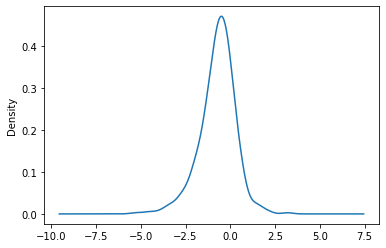

In [92]:
# Plot the review distribution - Maybe I'll do something with this later

summary.plot.kde()

In [93]:
summary.describe()

count    490.000000
mean      -0.715714
std        1.006146
min       -5.300000
25%       -1.200000
50%       -0.600000
75%       -0.100000
max        3.200000
Name: imdb, dtype: float64

In [95]:
#Write output to json format so it's easier to work with in javascript
json = output[['title_clean', 'series', 'date', 'imdb']].to_json(orient='records')

#Write it to the res directory
with open('../res/movieData.json', 'w') as f:
    f.write(json)